In [1]:
import cv2
from cv2 import SVDecomp
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


(327, 332)


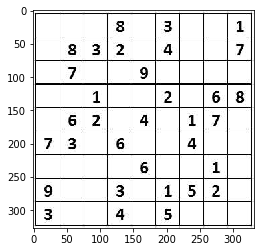

In [2]:
from PIL import Image

image = cv2.imread('/home/strahinja/Desktop/git/sudoku_solver/test_sudokus/test_16.jpg', cv2.IMREAD_GRAYSCALE)
img = image
# img = cv2.resize(img, (1000, 1000), interpolation = cv2.INTER_AREA)
print(img.shape)

plt.imshow(img, 'gray')

In [3]:
ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# img = cv2.cvtColor(img,cv2)

# Binary adaptive threshold using 11 nearest neighbour pixels
# img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

img = cv2.bitwise_not(img, img)

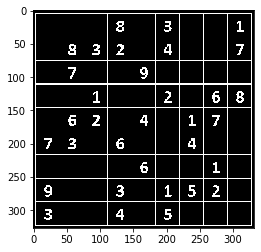

In [4]:
plt.imshow(img, cmap='gray')

In [5]:
kernel = (5,5)
img = cv2.dilate(img, kernel, iterations=1)

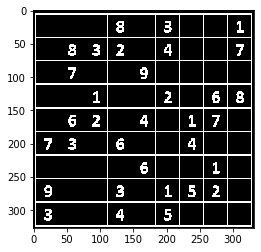

In [6]:
plt.imshow(img, cmap='gray')

In [7]:
_, contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [8]:
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

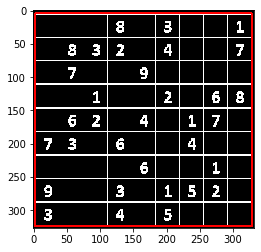

In [9]:
external_only = cv2.drawContours(img, contours, -1, (255, 0, 0), 2)
plt.imshow(external_only)

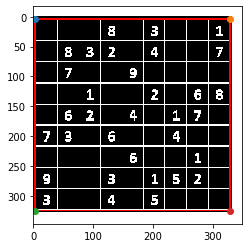

In [10]:
contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
contour = contours[0]
x,y,w,h = cv2.boundingRect(contour)
plt.imshow(img)
plt.scatter(x, y)
plt.scatter(x + w, y)
plt.scatter(x, y + h)
plt.scatter(x + w, y + h)

In [11]:
def distance_between(p1, p2):
    return np.sqrt(((p2[0] - p1[0]) ** 2) + ((p2[1] - p1[1]) ** 2))

In [12]:
top_left, top_right, bottom_right, bottom_left = (x,y), (x + w, y), (x + w, y + h), (x, y + h)

src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

side = max([
    distance_between(bottom_right, top_right),
    distance_between(top_left, bottom_left),
    distance_between(bottom_right, bottom_left),
    distance_between(top_left, top_right)
])

dst = np.array([[0, 0], [side, 0], [side, side], [0, side]], dtype='float32')

m = cv2.getPerspectiveTransform(src, dst)

img = cv2.warpPerspective(image, m, (int(side), int(side)))

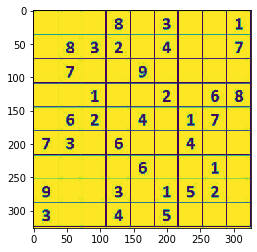

In [13]:
cv2.imwrite('processed.jpg', img)
plt.imshow(img)

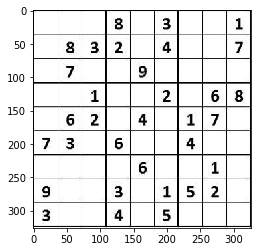

In [14]:
image = cv2.imread('processed.jpg')
plt.imshow(image)    

In [15]:
ret, img1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

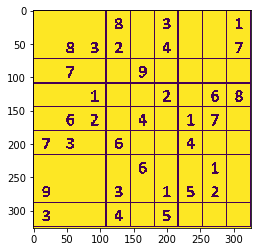

In [16]:
plt.imshow(img1)

In [17]:
def sort_horizontal (l):
    return l[0][1]

def sort_vertical (l):
    return l[0][0]

def calculate_new_horizontal(l_1, l_2, w):
    y = int((l_1[0][1] + l_2[0][1]) / 2)
    return [[0, y, w, y]]

def calculate_new_vertical(l_1, l_2, w):
    x = int((l_1[0][0] + l_2[0][0]) / 2)
    return [[x, 0, x, w]]

In [18]:
img = cv2.imread('processed.jpg')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 1
theta = np.pi / 180
threshold = 20
min_line_length = 100
max_line_gap = 20
line_image = np.copy(img) * 0

lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

horizontal = []
vertical = []
for line in lines:
    if line[0][1] == line[0][3]:
        horizontal.append(line)
    elif line[0][0] == line[0][2]:
        vertical.append(line)
        
horizontal.sort(key=sort_horizontal)

vertical.sort(key=sort_vertical)

horizontal_filtered = []
add_next = True
w = img.shape[0]

for i in range(0, len(horizontal) - 1):
    if horizontal[i + 1][0][1] - horizontal[i][0][1] < 10:
        horizontal_filtered.append(calculate_new_horizontal(horizontal[i], horizontal[i + 1], w))
        add_next = False
    else:
        if not add_next:
            add_next = True
        else:
            horizontal_filtered.append(horizontal[i])

if horizontal[len(horizontal) - 1][0][1] - horizontal[len(horizontal) - 2][0][1] < 10:
    horizontal_filtered.append(calculate_new_horizontal(horizontal[len(horizontal) - 2], horizontal[len(horizontal) - 1], w))
else:
    horizontal_filtered.append(horizontal[len(horizontal) - 1])
    
horizontal = np.array(horizontal_filtered)

vertical_filtered = []
add_next = True

for i in range(0, len(vertical) - 1):
    if vertical[i + 1][0][0] - vertical[i][0][0] < 10:
        vertical_filtered.append(calculate_new_vertical(vertical[i], vertical[i + 1], w))
        add_next = False
    else:
        if not add_next:
            add_next = True
        else:
            vertical_filtered.append(vertical[i])
            
if vertical[len(vertical) - 1][0][0] - vertical[len(vertical) - 2][0][0] < 10:
    vertical_filtered.append(calculate_new_vertical(vertical[len(vertical) - 2], vertical[len(vertical) - 1], w))
else:
    vertical_filtered.append(vertical[len(vertical) - 1])

vertical = np.array(vertical_filtered)

for line in horizontal:
    cv2.line(line_image,(line[0][0],line[0][1]),(line[0][2], line[0][3]),(255,0,0),3)
# cv2.line(line_image,(horizontal[7][0][0],horizontal[7][0][1]),(horizontal[7][0][2], horizontal[7][0][3]),(255,0,0),3)
    
for line in vertical:
    cv2.line(line_image,(line[0][0],line[0][1]),(line[0][2], line[0][3]),(255,0,0),3)
        
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

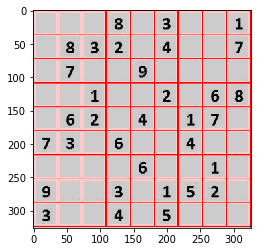

In [19]:
plt.imshow(lines_edges)

In [20]:
print('horizontal: ', len(horizontal))
print('vertical: ', len(vertical))

horizontal:  10
vertical:  10


In [21]:
def filter(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j][0] < 200 and image[i][j][1] < 200 and image[i][j][2] < 200:
                image[i][j] = 0
            else:
                image[i][j] = 255
    return image

def filter_1(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] < 200:
                image[i][j] = 0
            else:
                image[i][j] = 255
    return image


In [22]:
def prepare_image(im):
    
    im = cv2.resize(im, (1000, 1000) , interpolation = cv2.INTER_AREA)
    im = filter(im)
    
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#     im = cv2.GaussianBlur(im, (5, 5), 0)
#     im = cv2.adaptiveThreshold(im, 255, 1, 1, 11, 1)
#     im = cv2.bitwise_not(im, im)
    _, contours, hierarchy = cv2.findContours(im, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    
    entered = False
    
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        if x > 150:
            entered = True
            break
    
    if len(contours) == 0 or len(contours) == 1 or entered == False:
        im = im[100 : 900, 100 : 900]
        im = cv2.resize(im, (30, 30), interpolation = cv2.INTER_AREA)
        return im
    
#     print(x, y, w, h)
#     plt.scatter(x - 1, y - 1)
#     plt.scatter(x + w + 1, y - 1)
#     plt.scatter(x - 1, y + h + 1)
#     plt.scatter(x + w + 1, y + h + 1)
#     plt.imshow(im)
    
    im = im[y - 30 : y + h + 30, x - 30 : x + w + 30]
    im = cv2.resize(im, (30, 30), interpolation = cv2.INTER_AREA)
    im = filter_1(im)
    
    return im

# im = img[vertical[0][0][0] : vertical[1][0][0], 
#                     horizontal[4][0][1] : horizontal[5][0][1]]

# im = prepare_image(im)

In [23]:
from keras.models import load_model

model = load_model('neural.hdf5')

In [24]:
# # import matplotlib

# img_1 = img[vertical[0][0][0] : vertical[1][0][0], 
#                         horizontal[0][0][1] : horizontal[1][0][1]]

# plt.imshow(img_1)
# im = prepare_image(img_1)
# plt.imshow(im)

# # matplotlib.image.imsave(rootdir + '11_1.png', im)

# # rootdir = '/home/strahinja/Desktop/sudoku_solver_picture/digits/'

# # def add_to_dataset(image):
# #     numbers = [3,2,5,7,9,8,3,7,8,8,6,7,3,7,6,3,5,4,1,5,6,2,4,1,9,5,8,6]
    
# #     index = 0
    
# #     m = len(vertical)
# #     n = len(horizontal)
    
# # #     for i in range(m - 1):
# # #         for j in range(n - 1):
# #             img_1 = img[vertical[i][0][0] + 3 : vertical[i + 1][0][0] - 3, 
# #                         horizontal[j][0][1] + 3 : horizontal[j + 1][0][1] - 3]

# #             if (img_1.shape[0] < 10):
# #                 break
# #             elif(img_1.shape[1] < 10):
# #                 continue
# #             else:
# #                 boolean, im = prepare_image(img_1)
# #                 if boolean == True:
# #                     matplotlib.image.imsave(rootdir + '11_' + str(numbers[index]) + '.png', im)
# #                     index += 1
                    
# # add_to_dataset(img)

In [25]:
def predict_number(model, img):
    from PIL import Image
    from resizeimage import resizeimage
    
#     img = cv2.resize(img, (30, 30), interpolation = cv2.INTER_AREA)
#     img = np.array(img)
    try:
        img = prepare_image(img)
    except:
        return 0
    
#     img = np.mean(img, axis = 2)
    
    prediction = model.predict(img.reshape(1, 30, 30, 1))
    
    return np.argmax(prediction)

# plt.imshow(im)

# print(predict_number(model, im))

In [26]:
sudoku = [[], [], [], [], [], [], [], [], []]
sudoku_pom = [[], [], [], [], [], [], [], [], []]

In [27]:
m = len(vertical)
n = len(horizontal)

index = 0
passed = False

critical_vertical = []
critical_horizontal = []

for i in range(m - 1):
    passed = False

    for j in range(n - 1):
        img_1 = img[vertical[i][0][0] : vertical[i + 1][0][0], 
                    horizontal[j][0][1] : horizontal[j + 1][0][1]]
        
        if (img_1.shape[0] < 20):
            passed = True
            critical_vertical.append(i)
            break
        elif(img_1.shape[1] < 20):
            critical_horizontal.append(j)
            continue
        else:
            sudoku[index].append(predict_number(model, img_1))
            sudoku_pom[index].append(predict_number(model, img_1))
    
    if not passed:
        index = index + 1
    
print(np.matrix(sudoku))

[[0 0 0 8 0 3 0 0 1]
 [0 8 3 2 0 4 0 0 7]
 [0 7 0 0 9 0 0 0 0]
 [0 0 1 0 0 2 0 6 8]
 [0 6 2 0 4 0 1 7 0]
 [7 3 0 6 0 0 4 0 0]
 [0 0 0 0 6 0 0 1 0]
 [9 0 0 3 0 1 5 2 0]
 [3 0 0 4 0 5 0 0 0]]


In [28]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [29]:
def check_row(sudoku, i, number):
    for j in range(9):
        if sudoku[i][j] == number:
            return False
    return True

In [30]:
def check_column(sudoku, j, number):
    for i in range(9):
        if (sudoku[i][j] == number):
            return False
    return True

In [31]:
def check_square(sudoku, i, j, number):
    row = int(i / 3)
    column = int(j / 3)
    
    m = int(3 * (row + 1))
    n = int(3 * (column + 1))
    
    for i in range(int(3 * row), m):
        for j in range(int(3 * column), n):
            if sudoku[i][j] == number:
                return False

    return True

In [32]:
def finished(sudoku):
    for i in range(9):
        for j in range(9):
            if (sudoku[i][j] == 0):
                return False

    return True

In [33]:
def solve(sudoku, i, j):
    if (sudoku[i][j] == 0):
        for k in range(1, 10):
            if (check_row(sudoku, i, k) and check_column(sudoku, j, k) and check_square(sudoku, i, j, k)):
                sudoku[i][j] = k

                if (finished(sudoku)):
                    raise StopExecution

                if (j == 8):
                    solve(sudoku, i + 1, 0)
                else:
                    solve(sudoku, i, j + 1)

                sudoku[i][j] = 0
    else:
        if (j == 8):
            solve(sudoku, i + 1, 0)
        else:
            solve(sudoku, i, j + 1)

In [34]:
solve(sudoku, 0, 0)

In [ ]:
print(np.matrix(sudoku))

In [ ]:
print(np.matrix(sudoku_pom))

In [ ]:
index_i = 0
index_j = 0

distance = 4

for i in range(len(vertical)):
    if (index_i == 9):
            break
            
    if i in critical_vertical:
        continue
        
    index_j = 0
    
    for j in range(len(horizontal)):
        if (index_j == 9):
            break
            
        if j in critical_horizontal:
            continue

        if (sudoku_pom[index_i][index_j] == 0):
            shape = img[vertical[i][0][0] + distance : vertical[i + 1][0][0] - distance, 
                    horizontal[j][0][1] + distance : horizontal[j + 1][0][1] - distance].shape[0:2]
            
            digit_image = Image.open('digits/1_' + str(sudoku[index_i][index_j]) + '.png')
            digit_image = np.array(digit_image)
            digit_image = digit_image[:, :, :3]
            digit_image = cv2.resize(digit_image, (shape[1], shape[0]), interpolation = cv2.INTER_AREA)
            digit_image = np.array(digit_image)
            img[vertical[i][0][0] + distance : vertical[i + 1][0][0] - distance, 
                                horizontal[j][0][1] + distance : horizontal[j + 1][0][1] - distance] = digit_image
        index_j += 1
        
    index_i += 1

In [ ]:
plt.imshow(img)

In [ ]:
import matplotlib
matplotlib.image.imsave('/home/strahinja/Desktop/sudoku_solver_picture/solution.png', img)